In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.preprocessing import StandardScaler

import yfinance as yf

# Fetch historical data
data = yf.download('AAPL', start='2023-01-01', end='2024-03-27')

[*********************100%***********************]  1 of 1 completed


(149.10814819335937, 216.62042388916018)

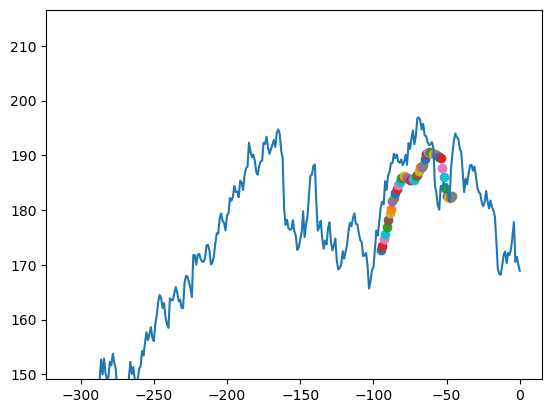

In [90]:
import matplotlib.pyplot as plt

class GPRPredictor:
    def __init__(self, start=-500, train_bars=100, shift_bars=0, length_scale=1.0, sigma_f=1, sigma_n=1):
        self.start = start
        self.train_bars = train_bars
        self.shift_bars = shift_bars
        self.kernel = Matern(length_scale=length_scale, nu=1.5) * sigma_f**2
        self.gpr = GaussianProcessRegressor(kernel=self.kernel, alpha=sigma_n**2, normalize_y=True)
        self.scaler = StandardScaler()

    def fit_predict(self, close_prices):
        X = np.arange(self.train_bars).reshape(-1, 1)
        
        y = close_prices[self.start:self.start + self.train_bars]
        
        y_scaled = self.scaler.fit_transform(y.reshape(-1, 1)).ravel()
        
        self.gpr.fit(X, y_scaled)
        
        X_pred = np.array([[self.train_bars + self.shift_bars - 1]])
        y_pred, std_pred = self.gpr.predict(X_pred, return_std=True)
        
        y_pred = self.scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()[0]
        std_pred = std_pred * self.scaler.scale_[0]
        
        return {
            'mean': y_pred,
            'ucb_95': y_pred + 1.96 * std_pred,
            'lcb_95': y_pred - 1.96 * std_pred,
            'ucb_997': y_pred + 3.0 * std_pred,
            'lcb_997': y_pred - 3.0 * std_pred
        }


for i in range(50):
    start_point = -200 + i
    bars = 100
    shift = 5

    # Initialize predictor
    gpr_predictor = GPRPredictor(start=start_point, train_bars=bars, shift_bars=shift)
    # Make prediction
    prediction = gpr_predictor.fit_predict(data['Close'].values)
    
    plt.scatter(start_point + bars + shift, prediction['mean'])
    plt.scatter(start_point + bars + shift, prediction['mean']+prediction['ucb_95'])
    plt.scatter(start_point + bars + shift, prediction['mean']+prediction['lcb_95'])

plt.plot([-i for i in range(len(data['Close'].values))[::-1]], data['Close'].values)

plt.ylim(min(data['Close'].values[start_point:]) * 0.9, max(data['Close'].values[start_point:]) * 1.1)